**Objectif du programme**



1.   Implémenter un AutoEncodeur en PyTorch

2.   L’entraîner sur la base de données MNIST

3.   Reconstruire des images de chiffres manuscrits

4.   Utiliser l’erreur de reconstruction pour faire de la détection d’anomalies

***Un autoencodeur est un réseau de neurones non supervisé qui apprend à compresser puis reconstruire les données d’entrée.***

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


Epoch 1/200, Loss = 0.0541
Epoch 2/200, Loss = 0.0284
Epoch 3/200, Loss = 0.0229
Epoch 4/200, Loss = 0.0196
Epoch 5/200, Loss = 0.0175
Epoch 6/200, Loss = 0.0160
Epoch 7/200, Loss = 0.0150
Epoch 8/200, Loss = 0.0141
Epoch 9/200, Loss = 0.0135
Epoch 10/200, Loss = 0.0131
Epoch 11/200, Loss = 0.0127
Epoch 12/200, Loss = 0.0123
Epoch 13/200, Loss = 0.0120
Epoch 14/200, Loss = 0.0117
Epoch 15/200, Loss = 0.0114
Epoch 16/200, Loss = 0.0112
Epoch 17/200, Loss = 0.0110
Epoch 18/200, Loss = 0.0108
Epoch 19/200, Loss = 0.0106
Epoch 20/200, Loss = 0.0105
Epoch 21/200, Loss = 0.0103
Epoch 22/200, Loss = 0.0102
Epoch 23/200, Loss = 0.0101
Epoch 24/200, Loss = 0.0100
Epoch 25/200, Loss = 0.0099
Epoch 26/200, Loss = 0.0098
Epoch 27/200, Loss = 0.0098
Epoch 28/200, Loss = 0.0097
Epoch 29/200, Loss = 0.0096
Epoch 30/200, Loss = 0.0095
Epoch 31/200, Loss = 0.0095
Epoch 32/200, Loss = 0.0094
Epoch 33/200, Loss = 0.0094
Epoch 34/200, Loss = 0.0093
Epoch 35/200, Loss = 0.0093
Epoch 36/200, Loss = 0.0092
E

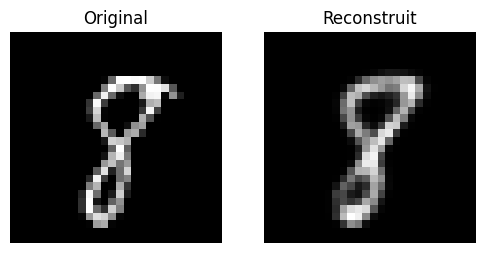

Erreur reconstruction normale : 0.010543091222643852
Erreur reconstruction anomalie : 0.08816049247980118


In [ ]:
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ======================
# 1. Load MNIST Dataset
# ======================
#La base MNIST contient des images de chiffres manuscrits de taille 28×28 pixels.

#ToTensor() :Convertit l’image en tenseur PyTorch  -> Normalise les pixels dans l’intervalle [0,1]
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# ======================
# 2. AutoEncoder Model
# ======================

#Rôle de l’encodeur (Compression):

#Transforme l’image 28×28 = 784 pixels → 256 → 64 → 16  pour réduit progressivement la dimension

#Cette étape permet d’extraire les caractéristiques importantes de l’image.

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16)  # latent space
        )

#Rôle du décodeur (Reconstruction):

#Reconstruit l’image originale à partir du vecteur latent

#Utilise Sigmoid() pour garantir des valeurs entre 0 et 1

#Reformate la sortie en image 1×28×28

        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ======================
# 3. Training
# ======================
epochs = 200
for epoch in range(epochs):
    total_loss = 0
    for batch, _ in train_loader:
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss = {total_loss/len(train_loader):.4f}")

# ======================
# 4. Test and Visualization
# ======================
def show(img):
    plt.imshow(img.squeeze().detach().numpy(), cmap="gray")
    plt.axis("off")

sample, _ = next(iter(test_loader))
reconstructed = model(sample)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); show(sample);        plt.title("Original")
plt.subplot(1,2,2); show(reconstructed); plt.title("Reconstruit")
plt.show()

# ======================
# 5. Anomaly Detection
# ======================
# On crée une anomalie : une ligne blanche ajoutée sur l'image
import numpy as np

anomaly = sample.clone()
anomaly[:, :, 10:12, :] = 1.0  # ligne horizontale

reconstructed_anomaly = model(anomaly)

original_error = torch.mean((sample - reconstructed)**2).item()
anomaly_error = torch.mean((anomaly - reconstructed_anomaly)**2).item()

print("Erreur reconstruction normale :", original_error)
print("Erreur reconstruction anomalie :", anomaly_error)
